# Multi-hop rag
The idea is to de-construct multihop questions in simpler ones. Then, there is a node that aggregates the answers.

In [1]:
# specify your working directory
working_dir = "/Users/pietromascheroni/open-modular-rag"
# specify the number of retrieved chunks
K = 5

In [2]:
from dotenv import load_dotenv
import os
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from torch import cuda
from typing import Callable
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import chromadb

import pandas as pd
import re
import string

## Set up the retriever

In [3]:
embed_model_id = 'sentence-transformers/all-mpnet-base-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device, 'batch_size': 32},
    cache_folder=working_dir + '/emb_model'
)

/Users/pietromascheroni/open-modular-rag/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/pietromascheroni/open-modular-rag/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# ChromaDB setup to initilize collection including indeces of all documents
# (in case of errors, perform pip uninstall chromadb and pip install chromadb)
chroma_client = chromadb.PersistentClient(path=working_dir + "/vectordb")

In [5]:
# provide a name to setup and reference the vector index
collection_name = "more_agents_paper_self_rag"
# initialize the vector index with the respective similarity search metric
vectorstore = chroma_client.get_or_create_collection(collection_name, metadata={"hnsw:space": "cosine"})

In [6]:
print(f"We have {vectorstore.count()} chunks in the vector store")

We have 139 chunks in the vector store


In [7]:
emb_query = embedding_model.embed_documents(['LLM performance'])
output = vectorstore.query(query_embeddings=emb_query, n_results=5, include=['distances','documents'])
output['documents']

[['task designed to isolate each one. Consider the task detailed below: To start the analysis, we select two datasets with increasing difficulty, i.e., GSM8K and MATH, to calculate the rela- tive performance gain. The relative performance gain η is given by: η = Pm−Ps where Pm and Ps are the perfor- mances (accuracy) with our method and a single LLM query, respectively. The results are shown in',
  'based on Table 2. Task Llama2-13B Llama2-70B GPT-3.5-Turbo GSM8K (easy) MATH (hard) 69 200 37 120 16 34 It is noteworthy that the relative performance gain is more substantial with increasing task difficulty. Specifically, we observe that within the same task, the smaller model, Llama2-13B, gains ranging from 28%-200%, but only 8%- 16% over GPT-3.5-Turbo. Moreover, the more challenging task MATH',
  'for a given task. Nodes represent steps, while dashed lines indicate alternative potential steps. The depth of nodes represents the number of steps, and the color intensity represents the level

In [8]:
# Load the vectordb as a langchain object
langchain_chroma = Chroma(
    client=chroma_client,
    collection_name=collection_name,
    embedding_function=embedding_model,
)

print("There are", langchain_chroma._collection.count(), "in the langchain-formatted collection")

There are 139 in the langchain-formatted collection


In [9]:
retriever = langchain_chroma.as_retriever(
    search_kwargs={'k': K,
                   #'filter': {'Page': '1'}
                   }
    )

test_query = "LLM performance"
retriever.invoke(test_query)

[Document(page_content='task designed to isolate each one. Consider the task detailed below: To start the analysis, we select two datasets with increasing difficulty, i.e., GSM8K and MATH, to calculate the rela- tive performance gain. The relative performance gain η is given by: η = Pm−Ps where Pm and Ps are the perfor- mances (accuracy) with our method and a single LLM query, respectively. The results are shown in', metadata={'Last Modified': '2024-05-02T21:13:10', 'Page': '6', 'Source': '/Users/pietromascheroni/open-modular-rag/docs/2402.05120v1.pdf'}),
 Document(page_content='based on Table 2. Task Llama2-13B Llama2-70B GPT-3.5-Turbo GSM8K (easy) MATH (hard) 69 200 37 120 16 34 It is noteworthy that the relative performance gain is more substantial with increasing task difficulty. Specifically, we observe that within the same task, the smaller model, Llama2-13B, gains ranging from 28%-200%, but only 8%- 16% over GPT-3.5-Turbo. Moreover, the more challenging task MATH', metadata={'La

## LLMs

### Query expander

In [10]:
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import JsonOutputParser
from dotenv import load_dotenv
import os

# Load environmental variables
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# set up the LLM
llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")


prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a query simplifier. \n
    You are given a question and your task is to expand it in multiple simpler questions. \n
    For example, if you are asked to compare two products, write a question for one product and a second one for the other product. \n
    Generate a maximum of 5 different additional queries. \n
    Provide a list of simplified questions as a JSON with a single key 'expanded_questions' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question"],
)

query_expander = prompt | llm | JsonOutputParser()
question = "Compare the performance for mathematical tasks and reasoning tasks."
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(query_expander.invoke({"question": question}))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'expanded_questions': ['What is the performance of mathematical tasks?', 'What is the performance of reasoning tasks?', 'How do mathematical tasks and reasoning tasks differ in terms of performance?', 'What are the strengths and weaknesses of mathematical tasks in terms of performance?', 'What are the strengths and weaknesses of reasoning tasks in terms of performance?']}


In [11]:
# # alternative initialization: this enforces directly the json format
# structured_llm = llm.with_structured_output(method="json_mode", include_raw=False)

# retrieval_grader_experimental = prompt | structured_llm
# print(retrieval_grader_experimental.invoke({"question": question, "document": doc_txt}))

### RAG generator

In [12]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an helpful assistant. \n
    You are given a question and your task is to answer it using the provided context. \n
    Use only the information provided in the context to formulate your answer. \n
    If you are not able to formulate an answer, respond "I am not able to formulate an answer". \n
    Use 3 sentences at maximum and keep your answer concise.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the context: {context} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["context","question"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Run
generation = rag_chain.invoke(question)
print(generation)

For mathematical tasks, the performance gains range from 1% to 15% on the MATH dataset. For reasoning tasks, the performance gains range from 1% to 13% on the Chess task and from 1% to 11% on the MMLU task.


### Answer merger

In [13]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an answer aggregator. \n
    You are given a list of answers and your task is to aggregate them in order to formulate a final answer to the provided user question. \n
    Provide a final answer as a JSON with a single key 'final_answer' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the list of answers: {list_of_answers} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["list_of_answers","question"],
)

answer_merger = prompt | llm | JsonOutputParser()
question = "Compare the performance for mathematical tasks and reasoning tasks."
list_of_answers = ["The models are very good for mathematical tasks.", "The accuracy for reasoning tasks is about 0.2."]

print(answer_merger.invoke({"list_of_answers": list_of_answers, "question": question}))

{'final_answer': 'The models are very good for mathematical tasks, but their accuracy for reasoning tasks is about 0.2.'}


## Build the graph using Langgraph

### Initialize the graph state

In [14]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        expanded_questions: LLM-expanded queries
        list_of_answers: list of answers to the expanded questions
        final_answer: final answer to the question
    """

    question: str
    expanded_questions: List[str]
    list_of_answers: List[str]
    final_answer: str

### Nodes

In [15]:
from langchain.schema import Document


def expand_query(state):
    """
    Expands the original query in multiple, simplified, ones.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, expanded_questions, that contains simplified questions
    """
    print("---NODE: QUERY EXPANSION---")
    question = state["question"]

    # Apply query expander
    expanded_questions_dict = query_expander.invoke(question)
    expanded_questions = expanded_questions_dict["expanded_questions"]
    
    print("The expanded queries are: ", expanded_questions)
    return {"expanded_questions": expanded_questions, "question": question}


def query_solver(state):
    """
    Generate answers to the expanded queries.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, list_of_answers, that contains RAG output for the expanded queries
    """
    print("---NODE: GENERATE ANSWERS TO EXPANDED QUERIES---")
    question = state["question"]
    expanded_questions = state["expanded_questions"]

    # RAG generation
    list_of_answers = []
    for query in expanded_questions:
        print("Answering query: ", query)
        list_of_answers += [rag_chain.invoke(query)]

    print("The list of answers reads: ", list_of_answers)
    return {"list_of_answers": list_of_answers, "expanded_questions": expanded_questions, "question": question}


def merge_the_answers(state):
    """
    Aggregates the responses from the expanded queries to resolve the initial user question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, final_answer, that contains the final answer to the user question
    """

    print("---NODE: ANSWERS AGGREGATION---")
    question = state["question"]
    expanded_questions = state["expanded_questions"]
    list_of_answers = state["list_of_answers"]

    # Aggregate the answers to the expanded queries
    final_answer_dict = answer_merger.invoke({"list_of_answers": list_of_answers, "question": question})
    final_answer = final_answer_dict["final_answer"]

    return {"final_answer": final_answer, "list_of_answers": list_of_answers, "expanded_questions": expanded_questions, "question": question}


### Build the graph

In [16]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("expand_query", expand_query) 
workflow.add_node("query_solver", query_solver)  
workflow.add_node("merge_the_answers", merge_the_answers)  

# Build graph
workflow.set_entry_point("expand_query")
workflow.add_edge("expand_query", "query_solver")
workflow.add_edge("query_solver", "merge_the_answers")
workflow.add_edge("merge_the_answers", END)

# Compile
app = workflow.compile()

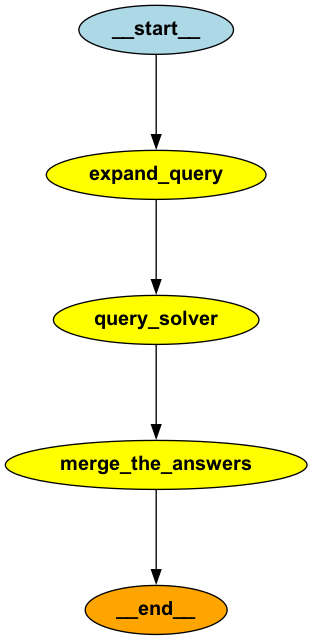

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_png()))
except:
    # This requires some extra dependencies and is optional
    print("doh")
    pass

### Run the multi-hop questions over the graph

In [18]:
from pprint import pprint

# Run
inputs = {"question": "Compare the LLM Self-Ensemble and Multiple LLM Agents Collaboration methods."}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value, indent=2, width=80, depth=None)
    print("\n---------\n")

# Final generation
pprint(value["final_answer"])

---NODE: QUERY EXPANSION---
The expanded queries are:  ['What are the key components of the LLM Self-Ensemble method?', 'How does the LLM Self-Ensemble method improve language model performance?', 'What are the advantages of using Multiple LLM Agents Collaboration?', 'How do Multiple LLM Agents Collaboration methods handle conflicting opinions?', 'What are the potential applications of each method in real-world scenarios?']
"Node 'expand_query':"
{ 'expanded_questions': [ 'What are the key components of the LLM '
                          'Self-Ensemble method?',
                          'How does the LLM Self-Ensemble method improve '
                          'language model performance?',
                          'What are the advantages of using Multiple LLM '
                          'Agents Collaboration?',
                          'How do Multiple LLM Agents Collaboration methods '
                          'handle conflicting opinions?',
                          'What are 